# Imports

In [2]:
# Standard library imports
import os
import json
import random
import warnings

# Data processing and numerical operations
import pandas as pd
import numpy as np

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable
%matplotlib inline

# Deep learning frameworks
import torch as pt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models

import kagglehub
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image

# Progress bar
from tqdm import tqdm

# Configure plotting
plt.style.use('fivethirtyeight')
sns.set_theme(style='whitegrid', palette='deep')

# Suppress warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Data Loading

## Dataset
Unsupervised Labeled Lane Markers (LLAMAS) Dataset is a computer vision dataset focused on lane detection and lane marker annotation. The dataset contains over 100,000 annotated images of road scenes with lane markers, designed to support unsupervised learning approaches in autonomous driving and road scene understanding.
LLAMAS provides a comprehensive collection of road scene images with high-resolution imagery at 1276 x 717 pixels, capturing lane markers with annotations extending over 100 meters. The dataset enables machine learning models to learn lane detection and lane marker segmentation without extensive manual labeling, leveraging advanced unsupervised learning techniques.
The dataset includes a wide range of lane marker variations, such as solid lines, dashed lines, double lines, and complex lane configurations, making it a robust resource for developing and testing lane detection algorithms in autonomous vehicle systems. With its extensive collection of over 100,000 annotated images, LLAMAS offers researchers and developers a rich, detailed dataset for advancing autonomous driving technologies.

Dataset structure
```json
{
    'grayscale_images': {
        'test': {'images-*',},
        'valid': {'images-*',},
        'train': {
            'images-*',
        }
    },
    'labels': {
        'labels': {
            'train': {'images-*',},
            'valid': {'images-*',}
        }
    }
}
```




In [11]:
large_dataset = kagglehub.dataset_download('vidityagi/llamas-grayscale')

In [12]:
def get_dataset_info(dataset_path):
    image_files = []
    label_files = []

    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.png'):
                image_files.append(os.path.join(root, file))
            elif file.endswith('.json'):
                label_files.append(os.path.join(root, file))

    # basic dataset info
    dataset_info = {
        'total_files': len(image_files) + len(label_files),
        'total_images': len(image_files),
        'total_labels': len(label_files),
    }

    # image dimension
    image_dims = []
    for img_path in image_files[:100]:
        with Image.open(img_path) as img:
            image_dims.append(img.size)
    unique_dims = set(image_dims)
    dataset_info['unique_image_dimensions'] = list(unique_dims)

    return dataset_info, image_files


dataset_info, image_files = get_dataset_info(large_dataset)
for key, value in dataset_info.items():
    print(f"{key}: {value}")

total_files: 0
total_images: 0
total_labels: 0
unique_image_dimensions: []


# EDA

In [ ]:
# image dimensions
print("Image Dimensions:")
unique_dims = dataset_info['unique_image_dimensions']
for dim in unique_dims:
    print(f"  height {dim[0]} x width {dim[1]}")

Image Dimensions:
  height 1276 x width 717


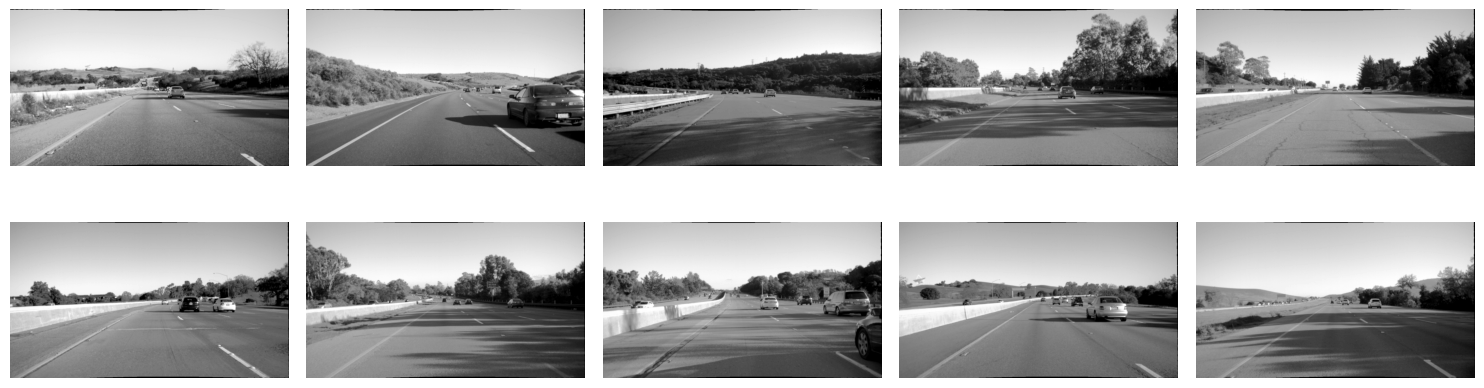

In [ ]:
# sample images visualization
plt.figure(figsize=(15, 5))
for i, img_path in enumerate(image_files[:10]):
    img = Image.open(img_path)
    plt.subplot(2, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# pixel value statistics
pixel_values = []
for img_path in image_files[:10]:
    img = np.array(Image.open(img_path))
    pixel_values.extend(img.flatten())

pixel_values = np.array(pixel_values)
print("Pixel Value Statistics:")
print(f"  Min Pixel Value: {pixel_values.min()}")
print(f"  Max Pixel Value: {pixel_values.max()}")
print(f"  Mean Pixel Value: {pixel_values.mean():.2f}")
print(f"  Median Pixel Value: {np.median(pixel_values):.2f}")
print(f"  Standard Deviation of Pixel Values: {pixel_values.std():.2f}")

Pixel Value Statistics:
  Min Pixel Value: 0
  Max Pixel Value: 255
  Mean Pixel Value: 142.40
  Median Pixel Value: 141.00
  Standard Deviation of Pixel Values: 67.38


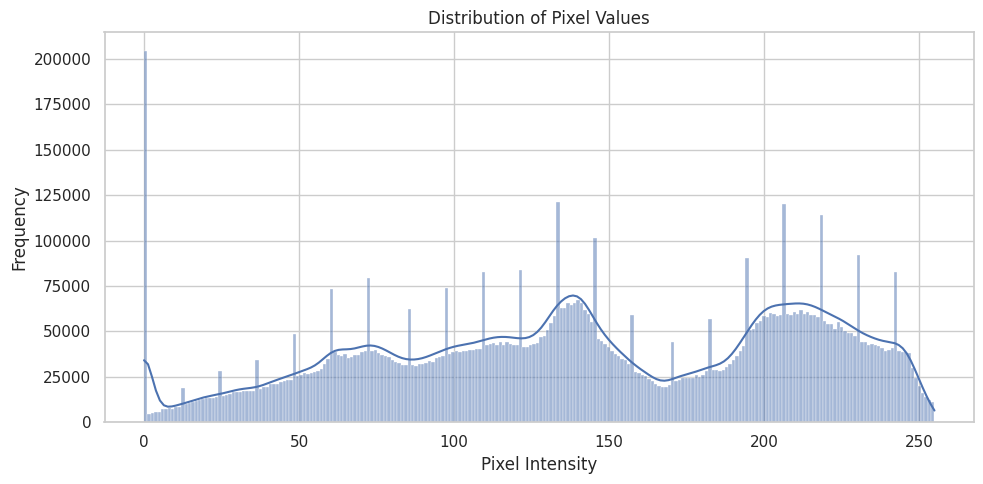

In [ ]:
# pixel value distribution
plt.figure(figsize=(10, 5))
sns.histplot(pixel_values, kde=True)
plt.title('Distribution of Pixel Values')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Pre-Processing

In [ ]:
def preprocess_images(image_files, target_size=(128, 128), normalize=True):
    preprocessed_images = []
    for img_path in image_files:
        # read the image in grayscale mode
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Warning: Unable to read image {img_path}. Skipping.")
            continue
        # resize image
        img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
        # normalize image
        if normalize:
            img = img.astype(np.float32) / 255.0
        preprocessed_images.append(img)

    return np.array(preprocessed_images)

preprocessed_images = preprocess_images(image_files, target_size=(128, 128))
print(f"Shape of preprocessed images array: {preprocessed_images.shape}")

New Dataset requiring different download code, eda and preprocessing

In [3]:
dataset = kagglehub.dataset_download('gjeevanm/object-detection-dataset')
train_path = dataset + '/tusimple_preprocessed/training'

In [4]:
img_generator = keras.preprocessing.image.ImageDataGenerator()

images_set = img_generator.flow_from_directory(
    train_path,
    color_mode='rgb',
    shuffle=False,
    batch_size=64,
    class_mode='binary',
    target_size=(256, 320)
)

images, labels = next(images_set)

print(f"Data type: {images.dtype}")
print(f"Max pixel value: {images.max()}")
print(f"Min pixel value: {images.min()}")

# if images.max() > 1.0:
#     images = images / 255.0

images = np.clip(images, 0, 255).astype(np.uint8)

print(f"Data type after conversion: {images.dtype}")
print(f"Max pixel value: {images.max()}")
print(f"Min pixel value: {images.min()}")

Found 7252 images belonging to 2 classes.
Data type: float32
Max pixel value: 255.0
Min pixel value: 0.0
Data type after conversion: uint8
Max pixel value: 255
Min pixel value: 0


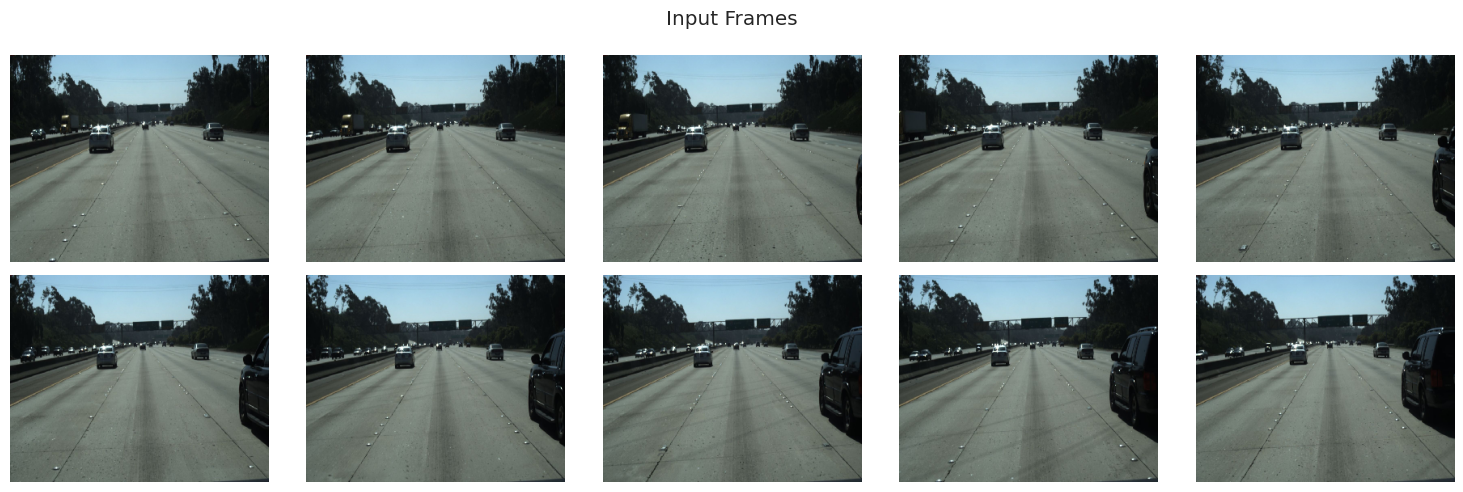

In [5]:
def plot_images(img_arr, title=None):
    n_images = len(img_arr)
    n_rows = (n_images + 5 - 1) // 5
    fig, axes = plt.subplots(n_rows, 5, figsize=(15, 5))

    axes = axes.flatten()
    for idx, ax in enumerate(axes):
        if idx < n_images:
            if len(img_arr[idx].shape) == 2:
                ax.imshow(img_arr[idx], cmap='gray')
            else:
                ax.imshow(img_arr[idx])
            ax.axis('off')
        else:
            ax.axis('off')

    if title is not None:
        plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_images(images[:10], title='Input Frames')

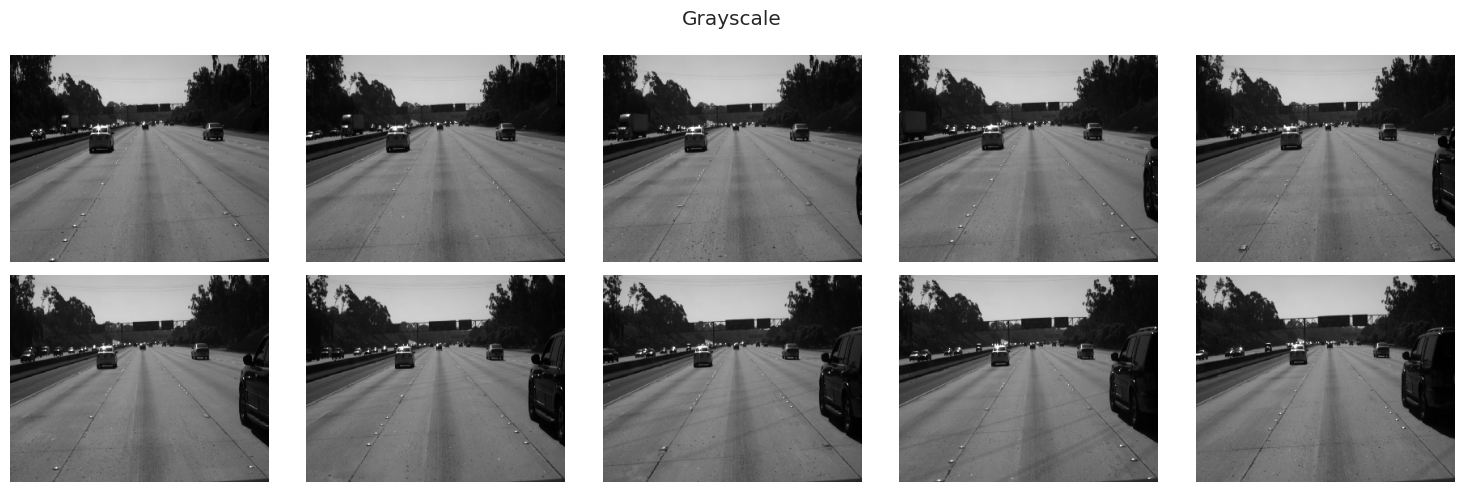

In [6]:
# convert to grayscale
grayscale_images = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in images])

# grayscale_images = grayscale_images / 255.0

plot_images(grayscale_images[:10], title='Grayscale')

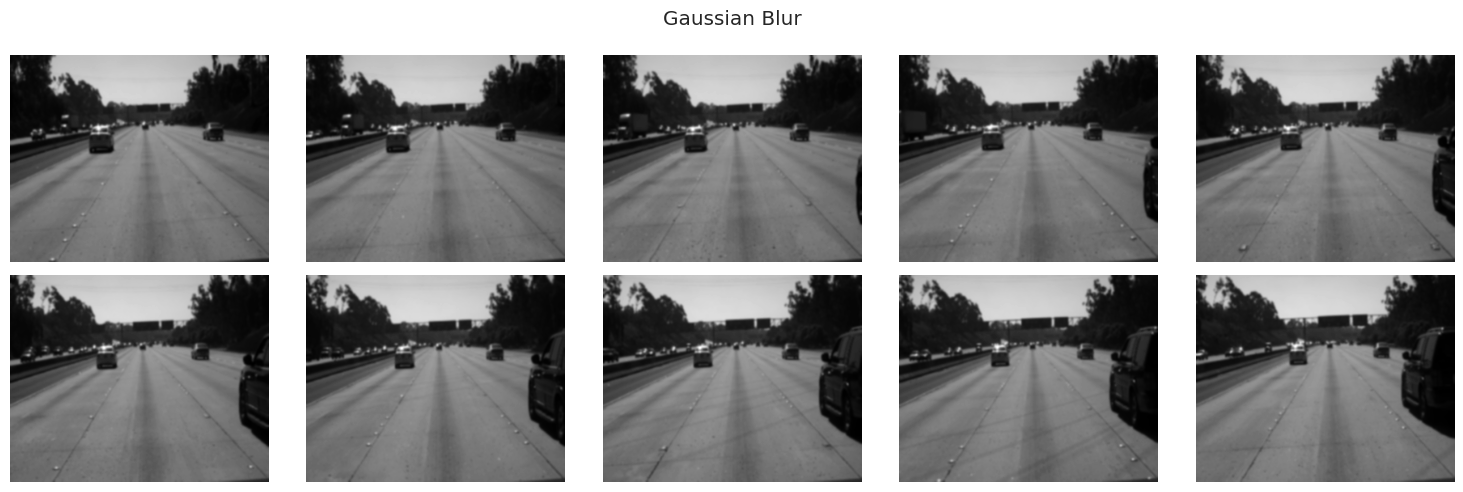

In [7]:
# guassian blur
kernel_size = 5

blurred_images = np.array([cv2.GaussianBlur(img, (kernel_size, kernel_size), 0) for img in grayscale_images])

plot_images(blurred_images[:10], title='Gaussian Blur')

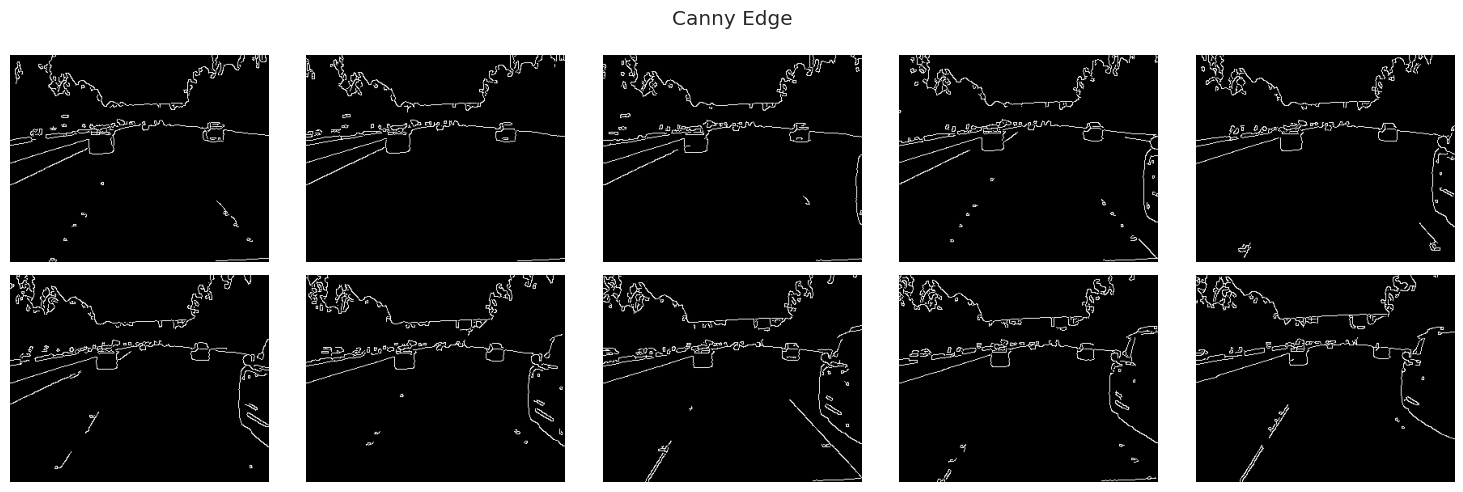

In [8]:
# canny edge detection
low_threshold = 50
high_threshold = 150

edges = np.array([cv2.Canny(img, low_threshold, high_threshold) for img in blurred_images])

plot_images(edges[:10], title='Canny Edge')

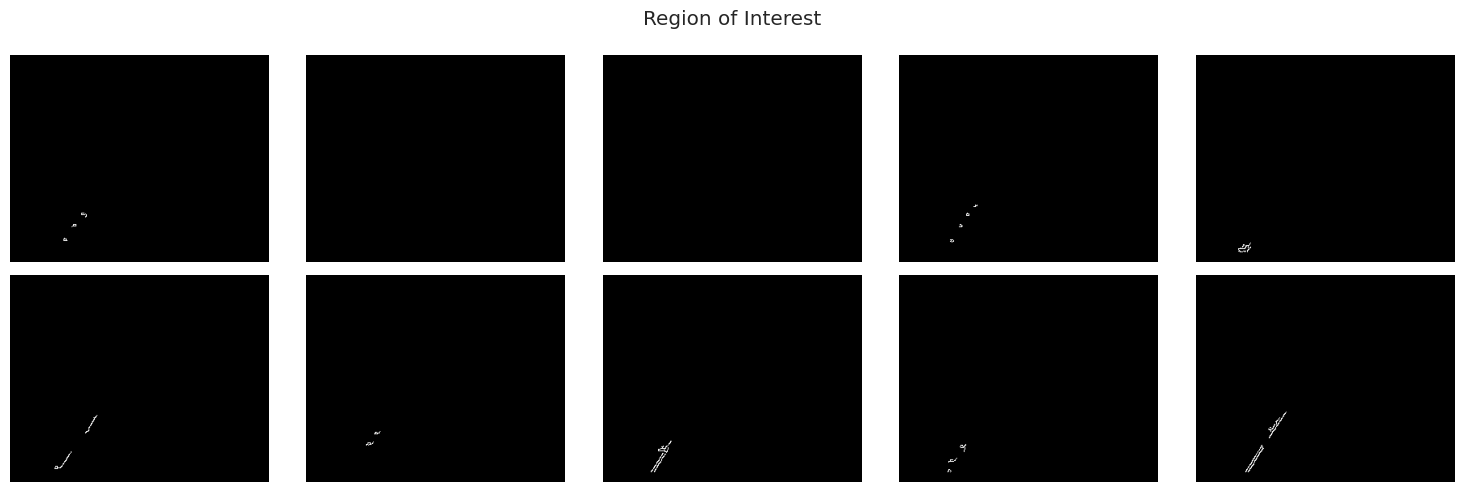

In [9]:
# region selection
def region_selection(image):
    mask = np.zeros_like(image)
    ignore_mask_color = 255

    rows, cols = image.shape[:2]
    bottom_left = [cols * 0.1, rows * 0.95]
    top_left = [cols * 0.4, rows * 0.6]
    bottom_right = [cols * 0.9, rows * 0.95]
    top_right = [cols * 0.6, rows * 0.6]
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)

    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

regions = np.array([region_selection(img) for img in edges])

plot_images(regions[:10], title='Region of Interest')

In [10]:
# hough transformation
def hough_transform(image):
    rho = 1
    theta = np.pi / 180
    threshold = 20
    min_line_length = 20
    max_line_gap = 300
    lines = cv2.HoughLinesP(
        image, rho, theta, threshold, minLineLength=min_line_length, maxLineGap=max_line_gap
    )
    return lines

hough_lines = [hough_transform(region) for region in regions]

print(hough_lines[:10])

[None, None, None, None, None, array([[[ 62, 238, 107, 173]]], dtype=int32), None, array([[[ 59, 243,  84, 205]],

       [[ 63, 243,  80, 214]]], dtype=int32), None, array([[[ 64, 243, 109, 171]],

       [[ 62, 242,  98, 181]],

       [[ 61, 243, 103, 176]]], dtype=int32)]


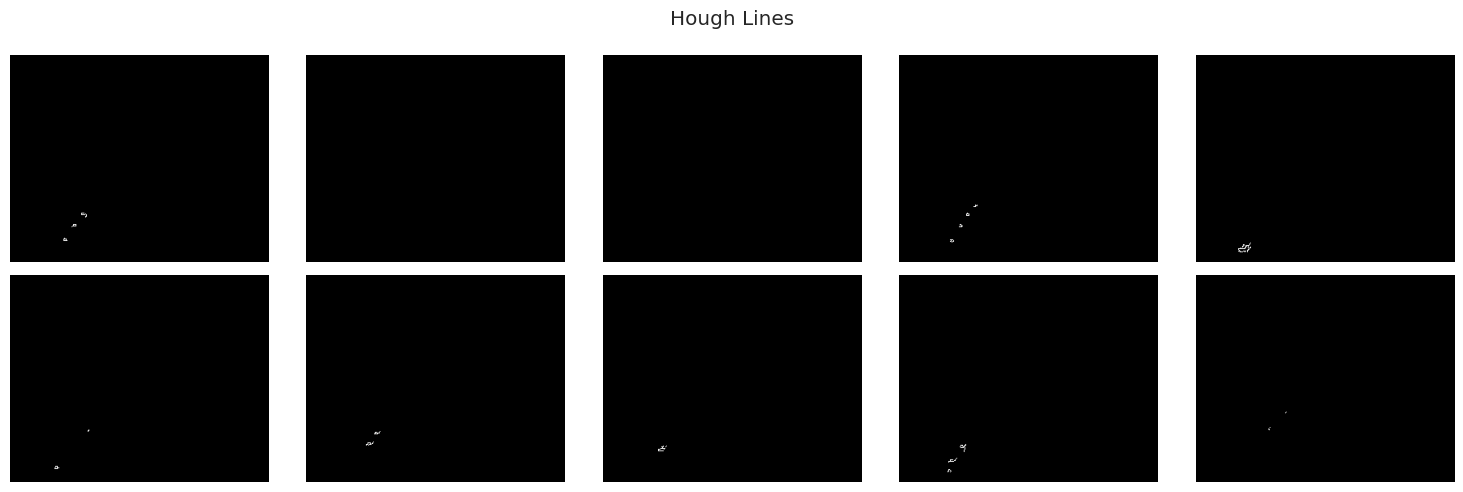

In [11]:
# plot lines
def draw_lines(image, lines):
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    return image

# filter out None values and draw lines only on valid images
images_with_lines = [
    draw_lines(region.copy(), lines) if lines is not None else region.copy()
    for region, lines in zip(regions, hough_lines)
]

plot_images(images_with_lines[:10], title='Hough Lines')

In [12]:
# Average slope and intercept calculation for left and right lanes
def average_slope_intercept(lines):
    left_lines = []  # (slope, intercept)
    left_weights = []  # (length,)
    right_lines = []  # (slope, intercept)
    right_weights = []  # (length,)

    for line in lines:
        for x1, y1, x2, y2 in line:
            if x1 == x2:
                continue
            # calculating slope and intercept
            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - (slope * x1)
            length = np.sqrt(((y2 - y1) ** 2) + ((x2 - x1) ** 2))

            # left lane has negative slope and right lane has positive slope
            if slope < 0:
                left_lines.append((slope, intercept))
                left_weights.append(length)
            else:
                right_lines.append((slope, intercept))
                right_weights.append(length)

    left_lane = np.dot(left_weights, left_lines) / np.sum(left_weights) if len(left_weights) > 0 else None
    right_lane = np.dot(right_weights, right_lines) / np.sum(right_weights) if len(right_weights) > 0 else None
    return left_lane, right_lane

# Convert the slope and intercept of each line into pixel points
def pixel_points(y1, y2, line):
    if line is None:
        return None
    slope, intercept = line
    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)
    return ((x1, y1), (x2, y2))

# Create full-length lines from pixel points for both left and right lanes
def lane_lines(image, lines):
    left_lane, right_lane = average_slope_intercept(lines)
    y1 = image.shape[0]  # Image height (bottom of the image)
    y2 = int(y1 * 0.6)   # y-value near the horizon
    left_line = pixel_points(y1, y2, left_lane)
    right_line = pixel_points(y1, y2, right_lane)
    return left_line, right_line


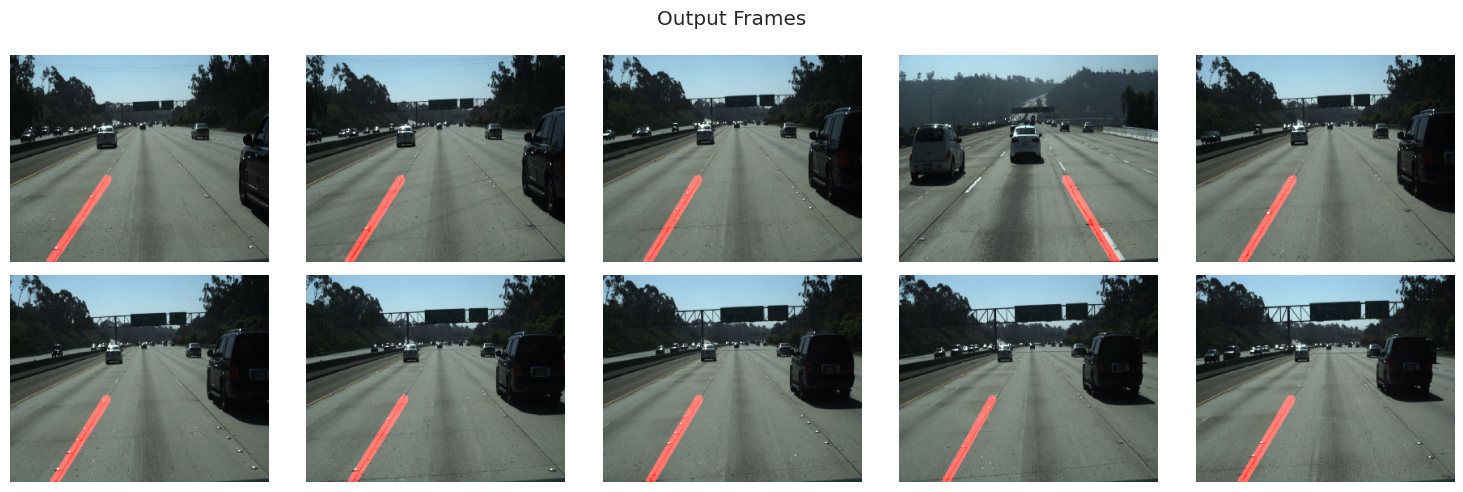

In [13]:
def draw_lane_lines(image, lines, color=(255, 0, 0), thickness=10):
    line_image = np.zeros_like(image)  # Create an empty image with the same size and channels as the original
    for line in lines:
        if line is not None:
            cv2.line(line_image, *line, color, thickness)
    return cv2.addWeighted(image, 1.0, line_image, 1.0, 0.0)  # Combine the original image with the lane lines

# Apply the lane line drawing to the original color images
images_with_lanes = []

for image, region, hough_line in zip(images, regions, hough_lines):
    if hough_line is not None:
        left_line, right_line = lane_lines(region, hough_line)
        images_with_lanes.append(draw_lane_lines(image, [left_line, right_line]))

plot_images(images_with_lanes[:10], title='Output Frames')

save output to google drive

In [14]:
from google.colab import drive
drive.mount('/content/drive')
import imageio


gif_path = '/content/drive/MyDrive/Colab Notebooks/project/lane_detection.gif'

with imageio.get_writer(gif_path, mode='I', duration=0.3) as writer:
    for img in images_with_lanes:
        writer.append_data(img)

print(f'GIF saved to: {gif_path}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
GIF saved to: /content/drive/MyDrive/Colab Notebooks/project/lane_detection.gif



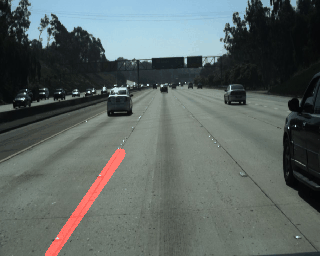

In [22]:
import base64
from IPython.display import HTML

# read, encode to base64, and display output gif
# execute cell to replay
with open(gif_path, "rb") as gif_file:
    gif_base64 = base64.b64encode(gif_file.read()).decode('utf-8')

gif_html = f'<img src="data:image/gif;base64,{gif_base64}" width="25%" autoplay loop>'
display(HTML(gif_html))

*Evaluation*

Difficulty detecting both lane lines simultaniously, and they also do not go that far down the image. Some tweaking of values will be needed to improve on this implementation.